In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_FP, plot_N, plot_N3D, out_axes, plot_FP_jitter, make_FP_axs, comp_eig_decomp
from tools_lnd import make_lil_axes, same_stim_trial, generate_Beta_epoch, gen_X_from_model_dir_epoch, make_D_use
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir
from tools_lnd import interp2d,gen_D_fp_qr,gen_mov_trial_set

In [2]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']##################

rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
ruleset = 'mem_motifs_small'
rule_trains = rules_dict[ruleset]
n_tasks = str(len(rule_trains))
rule_trains_str = '_'.join(rule_trains)
n_rnn = str(128)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = '3'
lr = -7
sigma_rec = 1/20
sigma_x = 2/20
w_rec_coeff  = 8/10
data_folder_all = 'data/rnn/multitask/stepnet/'
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)

net_name2 = '_sig_rec'+str(sigma_rec)+'_sig_x'+str(sigma_x)+'_w_rec_coeff'+"{:.1f}".format(w_rec_coeff)+'_'+rule_trains_str

m = os.path.join(p,'data','rnn','multitask',net,'final1',ruleset,rnn_type,activation,
    w_init,str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name+net_name2,str(seed))


In [3]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v4_figs','paper_figs','fig1','fig1_two_task_interp_explore',w_init)
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [4]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials('delaygo', hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    offset = np.repeat(params[3][:,np.newaxis],np.shape(h)[1],axis = 1)
    return np.dot(params[2].T,h)+offset

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    alpha = .2
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise
    
#     print(type(alpha),type(h),type(output))

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_delaygo_delayanti/3/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_delaygo_delayanti/3/model.ckpt


/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


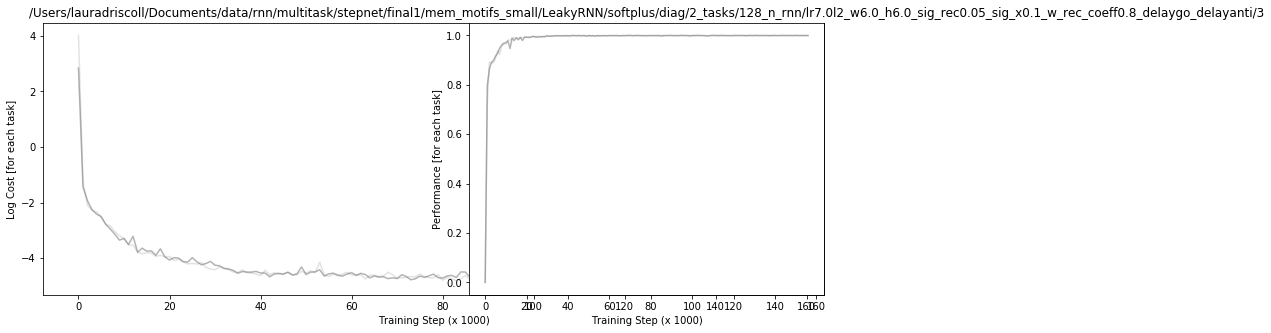

In [5]:
fig = plt.figure(figsize=(14, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')
task_list = hparams['rule_trains']

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    
    ax1 = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+task_list[r]])
    plt.plot(x,'-',c = c,alpha = .5)

    ax2 = fig.add_subplot(1,2,2)
    x = log_all['perf_'+task_list[r]]
    plt.plot(x,'-',c = c,alpha = .5)

ax1.set_xlabel('Training Step (x 1000)')
ax1.set_ylabel('Log Cost [for each task]')    
ax2.set_xlabel('Training Step (x 1000)')
ax2.set_ylabel('Performance [for each task]')
plt.title(m)
plt.show()    

In [6]:
'/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_delaygo_delayanti/1'

'/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_delaygo_delayanti/1'

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_delaygo_delayanti/3/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_delaygo_delayanti/3/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0'

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_delaygo_delayanti/3/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_delaygo_delayanti/3/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_

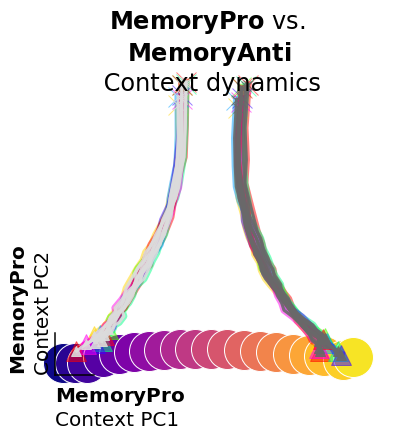

In [9]:
########## X TASK ###########
offset = 0
t_set = [offset, offset]
trial_num = [int(offset/4), int(offset/4)]

rule_set = [2,5]
epoch_set = ['fix1','fix1']
linestyle = ['-','-']
axs = 'pca_h'
tol_q = 1e-6
interp = True
script_name = 'interp_tasks_small_init_mov'

rule_axs = 1
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
ti = trial_num[rule_axs]
D_fix = make_D_use(m,rule,epoch,ti,axs)

trial_set = gen_mov_trial_set(m,rule_set)
D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs,epoch_set,trial_num)
D_diff = D_fp_qr[:,0]
D_end = D_fp_qr[:,1]
D_use = D_fp_qr[:,:2]
D_use[:,1] = -D_use[:,1]

interp2d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = 1e-6,interp = interp,
             cmap_grad = plt.get_cmap('plasma'),q_thresh = .000001,
            n_skip_interps=1, rule_axs = 0, plot_unstable = True, color_stim = True,figpath = figpath,
         fig_size = 6,alpha_max = 3,title_y = .8,only_rel = True, stability_thresh = 1.04)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_delaygo_delayanti/3/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_delaygo_delayanti/3/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0'

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_delaygo_delayanti/3/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_delaygo_delayanti/3/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_

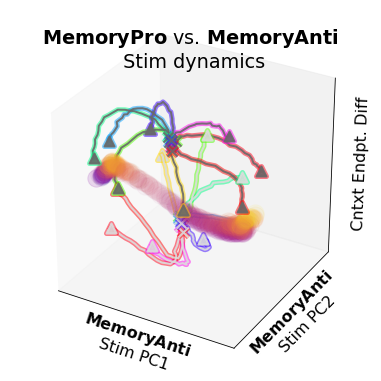

In [21]:
from tools_lnd import make_D_use, interp3d

script_name = 'interp_tasks_small_init_mov'

rule_set = [2,5]
linestyle = ['-','-']
axs = 'pca_h'
tol_q = 1e-6
interp = False
trial_num = [0,0]
t_set = [0,0]

rule_axs = 1
trial_set = gen_mov_trial_set(m,rule_set)
D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs, ['fix1','fix1'],trial_num)
D_diff = D_fp_qr[:,0]
D_end = D_fp_qr[:,1]
D_use = D_fp_qr[:,:2]

epoch_set = ['stim1','stim1']
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
ti = trial_num[rule_axs]
D_stim = make_D_use(m,rule,epoch,ti,axs)

D_use = D_stim
D_use[:,0] = -D_stim[:,0]
D_use[:,1] = D_stim[:,1]
# D_use[:,2] = D_fix[:,1]
D_use[:,2] = D_fp_qr[:,0]
# D_use[:,2] = w_out[:,2]

interp = True
fig_size = 5

epoch_set = ['stim1','stim1']
script_name = 'interp_tasks_small_init_stim'

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = .000001,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,lil_axes =False,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,alpha_max = 1.05,plot_zero_plane = False, 
         zlabel = 'Cntxt Endpt. Diff',ax_labels = [epoch, rule], stability_thresh = 1.04)

# D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs,epoch_set,trial_num)
# D_go = D_stim
# D_go[:,2] = D_fp_qr[:,0]

# epoch_set = ['delay1','delay1']
# script_name = 'interp_tasks_small_init_mov'
# # interp = False

# interp3d(m,D_go,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
#          interp = interp,q_thresh = .000001,rule_axs = rule_axs, plot_unstable = True,
#          n_skip_interps=1,lil_axes =False,color_stim = False,fig_size = fig_size,fontsize = 16,
#          figpath = figpath,ruleset = ruleset,alpha_max = 1.05,ax_labels = [epoch, rule],
#          zlabel = 'Memory Endpt. Diff',plot_zero_plane = False, n_trials = 0, stability_thresh = 1.04)


# D_go = D_stim
# D_go[:,2] = w_out[:,2]

# epoch_set = ['delay1','delay1']

# interp3d(m,D_go,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
#          interp = interp,q_thresh = .000001,rule_axs = rule_axs, plot_unstable = True,
#          n_skip_interps=1,lil_axes =False,color_stim = False,fig_size = fig_size,fontsize = 16,
#          figpath = figpath,ruleset = ruleset,alpha_max = 1.05,ax_labels = [epoch, rule], stability_thresh = 1.04)

# epoch_set = ['go1','go1']

# interp3d(m,D_go,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
#          interp = interp,q_thresh = .000001,rule_axs = rule_axs, plot_unstable = True,
#          n_skip_interps=1,lil_axes =False,color_stim = False,fig_size = fig_size,fontsize = 16,
#          figpath = figpath,ruleset = ruleset,alpha_max = 1.05,ax_labels = [epoch, rule], stability_thresh = 1.04)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_delaygo_delayanti/3/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_delaygo_delayanti/3/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0'

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_delaygo_delayanti/3/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_delaygo_delayanti/3/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_

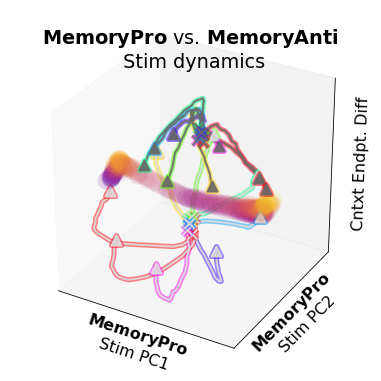

In [22]:
from tools_lnd import make_D_use, interp3d

script_name = 'interp_tasks_small_init_mov'

rule_set = [2,5]
linestyle = ['-','-']
axs = 'pca_h'
tol_q = 1e-6
interp = False
trial_num = [0,0]
t_set = [0,0]

rule_axs = 0
trial_set = gen_mov_trial_set(m,rule_set)
D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs, ['fix1','fix1'],trial_num)
D_diff = D_fp_qr[:,0]
D_end = D_fp_qr[:,1]
D_use = D_fp_qr[:,:2]

epoch_set = ['stim1','stim1']
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
ti = trial_num[rule_axs]
D_stim = make_D_use(m,rule,epoch,ti,axs)

D_use = D_stim
D_use[:,0] = -D_stim[:,0]
D_use[:,1] = -D_stim[:,1]
# D_use[:,2] = D_fix[:,1]
D_use[:,2] = D_fp_qr[:,0]
# D_use[:,2] = w_out[:,2]

interp = True
fig_size = 5

epoch_set = ['stim1','stim1']
script_name = 'interp_tasks_small_init_stim'

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = .000001,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,lil_axes =False,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,alpha_max = 1.05,plot_zero_plane = False, 
         zlabel = 'Cntxt Endpt. Diff',ax_labels = [epoch, rule], stability_thresh = 1.04)

# # interp = False
# epoch_set = ['delay1','delay1']
# script_name = 'interp_tasks_small_init_mov'
# D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs, epoch_set,trial_num)
# D_go = D_use
# D_go[:,2] = -D_fp_qr[:,0]

# interp3d(m,D_go,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
#          interp = interp,q_thresh = .000001,rule_axs = rule_axs, plot_unstable = True,
#          n_skip_interps=1,lil_axes =False,color_stim = False,fig_size = fig_size,fontsize = 16,
#          figpath = figpath,ruleset = ruleset,alpha_max = 1.05,ax_labels = [epoch, rule],
#          zlabel = 'Memory Endpt. Diff',plot_zero_plane = False, n_trials = 0, stability_thresh = 1.04)

# D_go[:,2] = w_out[:,2]

# epoch_set = ['delay1','delay1']
# script_name = 'interp_tasks_small_init_mov'

# interp3d(m,D_go,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
#          interp = interp,q_thresh = .000001,rule_axs = rule_axs, plot_unstable = True,
#          n_skip_interps=1,lil_axes =False,color_stim = False,fig_size = fig_size,fontsize = 16,
#          figpath = figpath,ruleset = ruleset,alpha_max = 1.05,ax_labels = [epoch, rule], stability_thresh = 1.04)


# epoch_set = ['go1','go1']
# script_name = 'interp_tasks_small_init_mov'

# interp3d(m,D_go,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
#          interp = interp,q_thresh = .000001,rule_axs = rule_axs, plot_unstable = True,
#          n_skip_interps=1,lil_axes =False,color_stim = False,fig_size = fig_size,fontsize = 16,
#          figpath = figpath,ruleset = ruleset,alpha_max = 1.05,ax_labels = [epoch, rule], stability_thresh = 1.04)

In [ ]:
# from tools_lnd import interp_h_tasks_w_context, gen_stim_trial_set

# ruleset = 'all'
# step_file = 'interp_tasks_small_init_mov'

# ri_set = [5,2]
# epoch_list = ['stim1','stim1']
# trial_set = gen_mov_trial_set(m, ri_set)
# interp_h_tasks_w_context(m,ri_set,trial_set,epoch_list,step_file = step_file,
#                          figpath = figpath,ruleset = ruleset)
# ri_set = [5,2]
# epoch_list = ['delay1','delay1']
# trial_set = gen_mov_trial_set(m, ri_set)
# interp_h_tasks_w_context(m,ri_set,trial_set,epoch_list,step_file = step_file,
#                          figpath = figpath,ruleset = ruleset)
# ri_set = [5,2]
# epoch_list = ['go1','go1']
# trial_set = gen_mov_trial_set(m, ri_set)
# interp_h_tasks_w_context(m,ri_set,trial_set,epoch_list,step_file = step_file,
#                          figpath = figpath,ruleset = ruleset)


In [15]:
def plot_stim_angles(ax,stim_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = True, two_task = False, show_rainbow = True):
        
    stim_cmap = plt.get_cmap('hsv')

    [x1,x2] = ax.get_xlim()
    x_diff = (x2-x1)/10
    [y1,y2] = ax.get_ylim()
    y_diff = (y2-y1)/10
    
    x_origin = x1+5*x_diff
    y_origin = y2+y_diff

    if show_rainbow:
        for theta in stim_locs:
            c = stim_cmap(theta/(2*np.pi))
            plt.plot([x_origin,x_origin+x_diff*np.cos(theta)],
                     [y_origin,y_origin+y_diff*np.sin(theta)],'-',c = c,alpha = .5,linewidth = 5)
        
        if show_stim:
            plt.text(x_origin+x_diff*np.cos(np.pi)*1.2,y_origin+y_diff*np.sin(np.pi/2)/4,
                     'Stimulus '+r'$\theta$',fontsize = 16,fontweight ='bold')
        else:
            plt.text(x_origin+x_diff*np.cos(np.pi)*1.4,y_origin+y_diff*np.sin(np.pi/2)/4,
                     'Response '+r'$\theta$',fontsize = 16,fontweight ='bold')
    
    
    if cat_task:
        plt.text(x_origin+x_diff*np.cos(0),y_origin-y_diff*np.sin(np.pi/2),'Category \n Boundary',fontsize = 14)
        plt.plot([x_origin-x_diff*np.cos(np.pi),x_origin+x_diff*np.cos(np.pi)],
                 [y_origin-y_diff*np.sin(np.pi),y_origin+y_diff*np.sin(np.pi)],':k',alpha = .9,linewidth = 3)
        
    if two_task:
        plt.plot([x_origin,x_origin+x_diff/2],[y_origin+3.5*y_diff,y_origin+3.5*y_diff],
                 '-',c = 'dimgray',alpha = .9,linewidth = 6)
        plt.scatter(x_origin,y_origin+3.5*y_diff,marker = 'x',c = 'dimgray',alpha = .9,s = 150,linewidth = 4)
        plt.text(x_origin+x_diff,y_origin+3.5*y_diff,'Task1',fontsize = 14,verticalalignment='center',fontweight ='bold')
        plt.scatter(x_origin+x_diff/2,y_origin+3.5*y_diff,marker = '^',c = 'dimgray',alpha = .9,s = 80,linewidth = 4)
        
        plt.plot([x_origin,x_origin+x_diff/2],[y_origin+2.5*y_diff,y_origin+2.5*y_diff],
                 '-',c = 'gainsboro',alpha = .9,linewidth = 6)
        plt.scatter(x_origin,y_origin+2.5*y_diff,marker = 'x',c = 'gainsboro',alpha = .9,s = 150,linewidth = 4)
        plt.scatter(x_origin+x_diff/2,y_origin+2.5*y_diff,marker = '^',c = 'gainsboro',alpha = .9,s = 80,linewidth = 4)
        plt.text(x_origin+x_diff,y_origin+2.5*y_diff,'Task2',fontsize = 14,verticalalignment='center',fontweight ='bold')
        
    remove_ax_lines(ax)
    ax.set_xticks([])
    ax.set_yticks([])


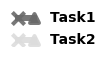

In [16]:
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(.4,.5),tight_layout=True,facecolor='white')
ax2 = fig.add_axes([0, 0, 1, 1])
stim1_locs = np.min(trial.stim_locs[0:-1:10,[0,2]],axis=1) #only workds for single modality tasks
plot_stim_angles(ax2,stim1_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = False, two_task = True, show_rainbow = False)

figname = 'task_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'task_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()

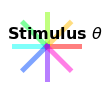

In [17]:
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(1,1),tight_layout=True,facecolor='white')
ax2 = fig.add_axes([0, 0, 1, 1])
plot_stim_angles(ax2,stim1_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = True, two_task = False)

figname = 'stim_angle_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'stim_angle_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()

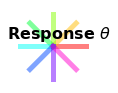

In [18]:
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(1,1),tight_layout=True,facecolor='white')
ax2 = fig.add_axes([0, 0, 1, 1])
plot_stim_angles(ax2,stim1_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = False, two_task = False)

figname = 'response_angle_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'response_angle_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()

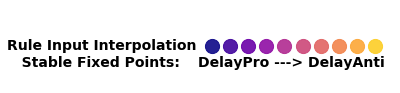

In [19]:
def interp_legend(ax,linewidth = 10, al = .9, markersize = 10,n_interp = 20,n_skip_interps = 2):
    cmap = plt.get_cmap('plasma')
    for step_i in range(0,n_interp,n_skip_interps):
        c = cmap(step_i/n_interp)
        ax.scatter(step_i-21.5,0,s = 200,marker = 'o',edgecolors = c,facecolors = c,alpha = al)
    plt.text(-n_interp-3,-.06,'DelayPro ---> DelayAnti',fontsize = 14,fontweight ='bold')
    plt.text(-2*n_interp-4,-.06,'Rule Input Interpolation \n   Stable Fixed Points:',fontsize = 14,fontweight ='bold')
        
    remove_ax_lines(ax)
    ax.set_xticks([])
    ax.set_yticks([])
#     [x1,x2] = ax.get_xlim()
#     [y1,y2] = ax.get_ylim()
#     ax.set_xlim([y1-3,y2])
    
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(2.6,1),tight_layout=True,facecolor='white')
ax = fig.add_axes([0, 0, 1, 1])
interp_legend(ax,linewidth = 10, al = .9, markersize = 10,n_interp = 20)

figname = 'interp_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'interp_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()

In [ ]:
# def fp_legend(ax,linewidth = 10, al = .9, markersize = 10,n_interp = 20,n_skip_interps = 2):
#     ax.scatter(0,1,s = 200,marker = 'o',edgecolors = 'k',facecolors = 'w',alpha = al)
#     ax.scatter(0,0,s = 200,marker = 'o',edgecolors = 'k',facecolors = 'k',alpha = al)
#     plt.text(0.04,1,'Unstable',fontsize = 14,verticalalignment = 'center',fontweight ='bold')
#     plt.text(0.04,0,'Stable',fontsize = 14,verticalalignment = 'center',fontweight ='bold')
#     plt.text(-0.04,2,'Fixed Points',fontsize = 14,verticalalignment = 'center',fontweight ='bold')
        
#     remove_ax_lines(ax)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     [x1,x2] = ax.get_xlim()
#     [y1,y2] = ax.get_ylim()
#     ax.set_ylim([y1-1,y2+1])
    
# fig = plt.figure(figsize=(1,1),tight_layout=True,facecolor='white')
# ax = fig.add_axes([0, 0, 1, 1])
# fp_legend(ax,linewidth = 10, al = .9, markersize = 10,n_interp = 20)


# figname = 'fp_legend.pdf'
# if not os.path.exists(figpath):
#     os.makedirs(figpath)
# plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

# figname = 'fp.png'
# plt.savefig(os.path.join(figpath,figname))
# plt.show()